### American Southwest Climate Analysis ###
Nick Vastine<br>
DTSA 5741 - Modeling Climate Anomalies<br>
Final Project

# 0. Introduction #
Anthropogenic climate change is a threat which will define the 21st century. The following analysis explores the changing climate of the American Southwest, considering the US states of California, Nevada, Utah, Colorado, Arizona, and New Mexico. The American Southwest is a generally a dry area at high risk of drought, which could be exacerbated the by El Nino Southern Oscillation (ENSO). The seasonal variation and propencity for longer-term dry conditions should result in dramatic changes to its climate history.

This analysis picks weather stations near population centers within each state to evaluate the change in temperature, precipitation, and groundwater levels since 2010.

As a technical final project, this report emphasizes API data sourcing, data manipulation, and comparative plotting for trends and distributions.

# 1. Data Sources #
This analysis explores six states, each represented by a NOAA and USGS weather station. The analysis assesss change over a 24 year period from January 1, 2010 through June 30, 2024. 

__NOAA Stations:__

Temperature and precipitation data is sourced from the [Climate Data Online Portal](https://www.ncdc.noaa.gov/cdo-web/search) from the National Oceanic and Atmospheric Administration (NOAA). The following weather stations represent each state across the American Southwest.

* _Arizona_ - PHOENIX AIRPORT, AZ US - GHCND:USW00023183
* _California_ - SAN DIEGO INTERNATIONAL AIRPORT, CA US - GHCND:USW00023188
* _Colorado_ - DENVER INTERNATIONAL AIRPORT, CO US - GHCND:USW00003017
* _Nevada_ - LAS VEGAS AIR TERMINAL, NV US - GHCND:USW00053123
* _New Mexico_ - ALBUQUERQUE INTERNATIONAL AIRPORT, NM US - GHCND:USW00023050
* _Utah_ - SALT LAKE CITY INTERNATIONAL AIRPORT, UT US - GHCND:USW00024127

Airports appear to be reliable source of temperature and precipitation information, understandable given their need for flight conditions.

__USGS Stations:__

This analysis also considers groundwater measurements from nearby USGS stations. Note Utah has been excluded since its USGS stations are far from the NOAA station or exclusively report groundwater minimums.

* _Arizona_ - 324953112151401
* _California_ - 324641117071505 
* _Colorado_ - 393902103554001 
* _Nevada_ - 361704115121901
* _New Mexico_ - 344431106393403
* _Utah*_ - Excluded from this analysis

## 1.1 Data Import ##
### 1.1.1 NOAA API Import ###
The following code first requests datasets from the NOAA stations, which include Air Temperature (Average, Minimum, Maximum) and Precipitation information. Note the API Token has been hidden for security purposes.

The API import process was surprisingly complex as each data entry (ex. TMAX for Arizona on 1/1/2020) is returned as an individual record. For 4 data points (TMAX, TMIN, TAVG, PRCP) per station (6) per day (365) per year (24 years), that is 122,640 items to import.

The API restricts export files to 1000 records. Thus, the API import is written to incrementally import, rearrange, and consolidate the records. It does so by importing in 6-month increments where each NOAA station is imported individually. The data is reformatted from a long format to a wide format, then consolidated and saved locally.

Given the 100+ calls using the API, calls occasionally return a `503: Server Unavailable` status. In these cases, the code simply calls the API again and again until it succeeds.

In [1]:
import requests
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
## API is limited to 1000 items per call. 
# For 4 data points (TMAX, TMIN, TAVG, PRCP) per station (6) per day (365) per year (24 years).
# 122,640 items, or minimum 123 calls to the API.
# Call twice per year per station per year = 2 * 6 * 20 = 240 calls.
# Calling twice per year stays below API 1000 record limit.
# Related documentation - https://www.ncdc.noaa.gov/cdo-web/webservices/v2#data

# Date Range - Generating date list of 6-month increments.
date_list = []
for year in range(2010,2025):
    for month_start,month_end in [("-01-01","-06-30"),("-07-01","-12-31")]:
        if (year == 2024) & (month_start == "-07-01"):
                break # hard coding end condition
        else:
            date_list.append((str(year)+month_start,str(year)+month_end))   

# Station List
station_list = ['GHCND:USW00023183','GHCND:USW00023188','GHCND:USW00003017','GHCND:USW00053123','GHCND:USW00023050','GHCND:USW00024127']

# HTTP Requests
url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/data'
headers = {'token':'token'} # Passed in requests

df_NOAA = pd.DataFrame() # Initialize dataframe

# Import incrementally, by date...
for start,end in date_list: 
    print("Current Date Import: ",start,end)
    # ... and by station
    for station in station_list: 
        # print(i, station, start, end)
        # HTTP Request
        payload = {'datasetid':'GHCND','stationid':station,'startdate':start, 'enddate':end, 'datatypeid':['TAVG','TMAX','TMIN','PRCP'], 'limit':1000, 'units':'standard'}
        r = requests.get(url, params=payload, headers=headers)
        while r.status_code == 503: # Check for server unavailable
            print("Request Error: ", r.status_code) 
            r = requests.get(url, params=payload, headers=headers) # re-run request if server was unavailable until it works
        r.raise_for_status()  # raises exception when not a 2xx response
        # Processing Request
        data = r.json()
        live_df = pd.json_normalize(data['results']) # Data is imported such that each station/date/item is its own line
        grouped_df = live_df.groupby(['station','date', 'datatype'])['value'].first().unstack().reset_index() 
            # groupby() put values in station/date/datatype order.
            # first() takes the first value of each group (if there were redundancies)
            # unstack() pivots from long to wide format based on the datatype
        # Saving data
        df_NOAA = pd.concat([df_NOAA, grouped_df], ignore_index = True) # Add to running total
        df_NOAA.to_csv("NOAA Data Export.csv")
print("Import Complete!")
df_NOAA.to_csv("NOAA Data Export - Complete.csv")

The data is incrementally saved to a spreadsheet. The final spreadsheet can be imported to avoid the API process for convenience.

In [6]:
# ## Backup Import Code
df_NOAA = pd.read_csv("NOAA Data Export - Complete.csv") # Note the file was manually renamed to avoid overwriting
df_NOAA.drop('Unnamed: 0', axis=1, inplace=True)
df_NOAA = df_NOAA.rename(columns={'Unnamed: 0':'datatype'})

The data is then cleaned by relabeling stations as their representative states and re-encoding date information. 

In [7]:
# NOAA Data Clean-up
## Stations -> States
NOAA_states = ['Arizona', 'California', 'Colorado', 'Nevada', 'New Mexico', 'Utah']
station_state_dict = dict(zip(station_list,NOAA_states))
df_NOAA['station'] = df_NOAA['station'].astype(str)
df_NOAA['station'] = df_NOAA['station'].map(station_state_dict) # Mapping from dict
## Datetime -> Dates
df_NOAA['date'] = pd.to_datetime(df_NOAA['date'])
df_NOAA['date'] = df_NOAA['date'].dt.date
## Rename columns
df_NOAA = df_NOAA.rename(columns={'station':'State','date':'Date','PRCP':'Precipitation','TMAX':'Max.Temp','TMIN':'Min.Temp','TAVG':'Avg.Temp'})
## Set index
df_NOAA.set_index(['State','Date'], inplace=True)
df_NOAA.head()

Precipitation  Max.Temp  Min.Temp  Avg.Temp
State   Date                                                   
Arizona 2010-01-01            0.0      68.0      41.0       NaN
        2010-01-02            0.0      71.0      45.0       NaN
        2010-01-03            0.0      71.0      42.0       NaN
        2010-01-04            0.0      74.0      45.0       NaN
        2010-01-05            0.0      73.0      45.0       NaN

Finally the data is inspected for null values. This dataset includes many null values, especially affecting the average temperature data. However, this analysis does not drop these null values as it would remove many otherwise suitable data points, and it does not impute since there is other data to draw the trends from.

In [8]:
print("NA by State by Datatype")
df_NOAA.isna().groupby(['State']).sum()

NA by State by Datatype


,Precipitation,Max.Temp,Min.Temp,Avg.Temp
State,,,,
Arizona,0,0,0,1192
California,0,0,0,1186
Colorado,0,60,60,1337
Nevada,13,2,3,5291
New Mexico,0,0,0,1186
Utah,0,0,0,1186


### 1.1.2 USGS API Import ###
We will also import groundwater data from USGS. Luckily the data is provided in a more convenient structure and without a record limit.

The data is then cleaned similar to the NOAA data, but this time using median groundwater data to impute absent mean groundwater data.

In [9]:
import dataretrieval.nwis as nwis

In [10]:
sites = [324953112151401,324641117071505,393902103554001,361704115121901,344431106393403]

## API
df_USGS = nwis.get_record(sites=sites, service='dv', start='2010-01-01', end='2024-09-30') # Daily values
## Clean up
df_USGS.reset_index(inplace=True)
# Impute / Combine
df_USGS['72019_Mean'] = df_USGS['72019_Mean'].fillna(df_USGS['72019_Median']) # Using median values where mean is missing
# Reduce data
df_USGS = df_USGS[['site_no','datetime','72019_Mean']]
# Clean up dtypes 
df_USGS['datetime'] = df_USGS['datetime'].dt.date
# Replace site_no with site_names
df_USGS['site_no'] = df_USGS['site_no'].astype("int64") # Need to set as int64 for mapping to work
USGS_states = ['Arizona', 'California', 'Colorado', 'Nevada', 'New Mexico']
site_state_dict = dict(zip(sites,USGS_states))
df_USGS['site_no'] = df_USGS['site_no'].map(site_state_dict) # Mapping from dict
# Rename columns
df_USGS = df_USGS.rename(columns={'datetime':'Date','72019_Mean':'Groundwater Level','site_no':'State'})
# Confirmatory wipe
df_USGS.dropna() 
# Reporting
df_USGS.set_index(['State','Date'], inplace=True)
df_USGS.to_csv("USGS Data Export - Complete.csv")
print("Samples:", len(df_USGS))
df_USGS.notna().groupby(['State']).sum()

Samples: 21998


,Groundwater Level
State,
Arizona,2834
California,3814
Colorado,3773
Nevada,5180
New Mexico,4938


# 2. Example Analysis #
We will first evaluate the data for Colorado before comparing trends between states. This allows us to understand the structure of the visualizations in detail without the complication of multiple datasets.

## 2.1 Temperature ##
### 2.1.1 Scatter Plot ###
The following plot compares the temperature measurements for Colorado. Each measurement is plotted as a point, which is color-coded red, purple, and blue for the day's maximum, average, and minimum temperature respectively.

The seasonal variation in temperature is apparent in these plots, highlighting hot summers and cold winters. However, it does not clearly demonstrate long term trends in maximum, average, or minimum temperature necessary for climate analysis. The plot also makes the gap in reporting in 2013 apparent.

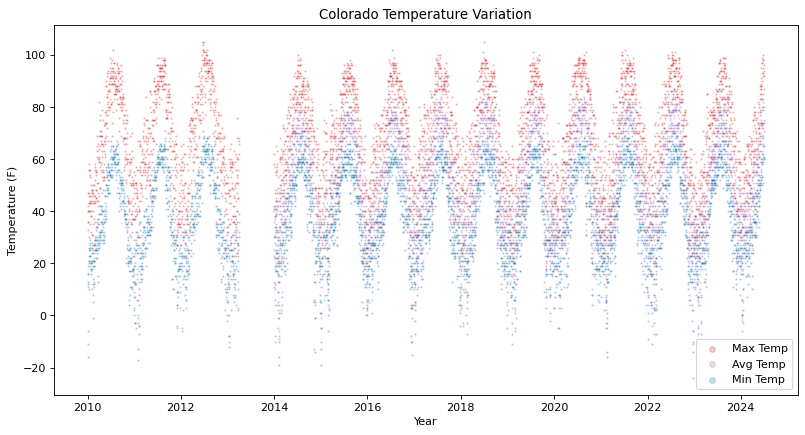

In [11]:
# df_NOAA.reset_index(inplace=True)
plt.figure(figsize=(12, 6), dpi=80)
CO_NOAA = df_NOAA.iloc[df_NOAA.index.get_level_values(0).str.contains('Colorado')]
CO_NOAA.reset_index(inplace=True)
x = CO_NOAA['Date']
plt.scatter(x,CO_NOAA['Max.Temp'], s=1, c='tab:red', alpha=0.25, label="Max Temp")
plt.scatter(x,CO_NOAA['Avg.Temp'], s=1,  c='tab:purple', alpha=0.25, label="Avg Temp")
plt.scatter(x,CO_NOAA['Min.Temp'], s=1,  c='tab:blue', alpha=0.25, label="Min Temp")
plt.legend(loc = 'lower right', markerscale = 5)
plt.title("Colorado Temperature Variation")
plt.ylabel("Temperature (F)")
plt.xlabel("Year")
plt.show()

### 2.1.2 Smoothing ###
It was quite difficult to implement a smoothed spline or other smooth line fit in Python. Instead, a 1-month moving average of the data was calculated to help interpret temperature trends over time. 

A 1-month moving average uses the 15 days preceeding and 15 days following the date of interest to provide an average temperature. This helps smooth noise and allows us to identify long term change in temperature. If the average line increases, this implies long term warming in that region.

In [12]:
# Moving average function
def moving_average(df, window_size = 30):
    Max_Moving_Avg = []
    Avg_Moving_Avg = []
    Min_Moving_Avg = []
    Prec_Moving_Avg = []
    i = 0
    # Creating Moving Averages
    while i < len(df['Max.Temp']) - window_size:
        Max_Moving_Avg.append(np.mean(df['Max.Temp'].iloc[i:i+window_size]))
        Avg_Moving_Avg.append(np.mean(df['Avg.Temp'].iloc[i:i+window_size]))
        Min_Moving_Avg.append(np.mean(df['Min.Temp'].iloc[i:i+window_size]))
        Prec_Moving_Avg.append(np.mean(df['Precipitation'].iloc[i:i+window_size]))
        i += 1
    NA_indexing = list(np.repeat(None, window_size//2))    
    # Adjusting indexing
    Max_Moving_Avg = NA_indexing + Max_Moving_Avg + NA_indexing
    Avg_Moving_Avg = NA_indexing + Avg_Moving_Avg + NA_indexing
    Min_Moving_Avg = NA_indexing + Min_Moving_Avg + NA_indexing
    Prec_Moving_Avg = NA_indexing + Prec_Moving_Avg + NA_indexing
    # Writing to dataframe
    df["Max.Moving.Avg"] = Max_Moving_Avg
    df["Avg.Moving.Avg"] = Avg_Moving_Avg
    df["Min.Moving.Avg"] = Min_Moving_Avg 
    df["Prec.Moving.Avg"] = Prec_Moving_Avg 

In [13]:
moving_average(CO_NOAA,window_size = 30)

In [14]:
# Temperature moving average plotting function
def temp_moving_average_plot(df,state = "Colorado", window=""):
    plt.figure(figsize=(12, 6), dpi=80)
    x = df['Date']
    plt.scatter(x,df['Max.Temp'], s=1, c='tab:red', alpha=0.1, label="Max Temp")
    plt.scatter(x,df['Avg.Temp'], s=1,  c='tab:purple', alpha=0.1, label="Avg Temp")
    plt.scatter(x,df['Min.Temp'], s=1,  c='tab:blue', alpha=0.1, label="Min Temp")
    # PLotting moving averages
    plt.plot(x,df['Max.Moving.Avg'], c='tab:red', alpha = 0.5)
    plt.plot(x,df['Avg.Moving.Avg'], c='tab:purple', alpha = 0.5)
    plt.plot(x,df['Min.Moving.Avg'], c='tab:blue', alpha = 0.5)
    plt.legend(loc = 'lower right', markerscale = 5)
    plt.ylabel("Temperature (F)")
    plt.xlabel("Year")
    plt.title(str(state)+" - Temperature Variation - Moving Average " + str(window))

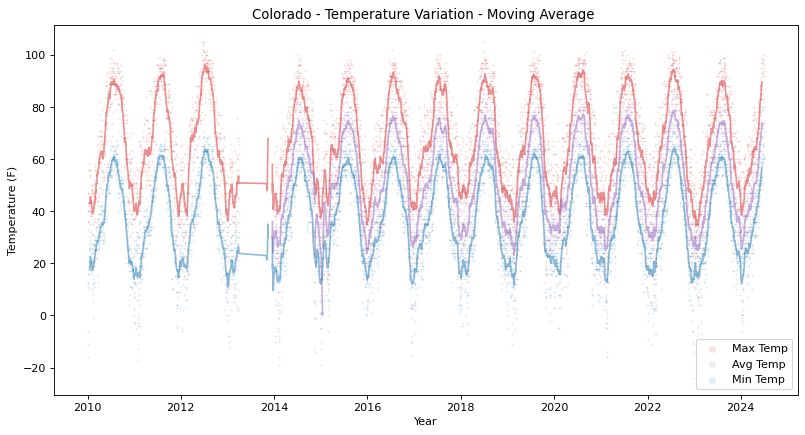

In [15]:
temp_moving_average_plot(CO_NOAA)

Adding the 1-month moving average to the plot helps visualize the long term trends. For example, it makes the increase in overall maximum temperature from 2010 through 2012 more distinct.

By adjusting the window size for the moving average, we can further smooth the monthly and seasonal variation to see trends over time. Below plots a 3-month, 6-month, and 12-month moving average for comparison.

The 12-month moving average makes the annual variation more apparent, with mixed periods of increasing and decreasing temperature.

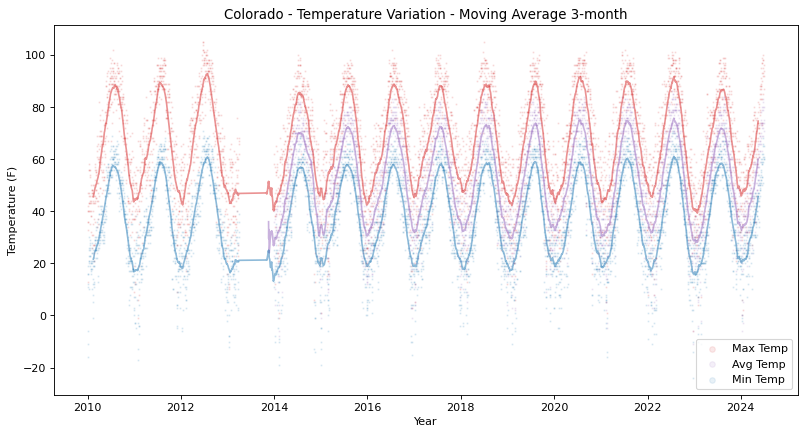

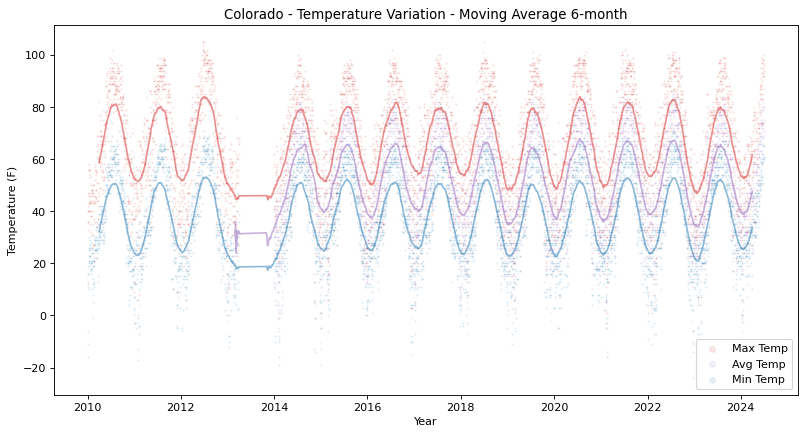

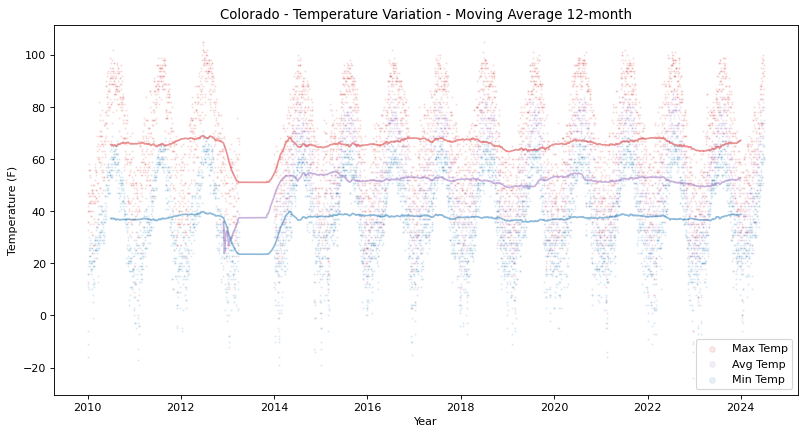

In [16]:
moving_average(CO_NOAA,window_size = 90)
temp_moving_average_plot(CO_NOAA, window = "3-month")
moving_average(CO_NOAA,window_size = 182)
temp_moving_average_plot(CO_NOAA, window = "6-month")
moving_average(CO_NOAA,window_size = 364)
temp_moving_average_plot(CO_NOAA, window = "12-month")

### 2.1.3 Histogram ###
We can also consider the distribution of temperature using histograms. Below presents the histograms for maximum, average, and minimum temperature for Colorado for comparison.

As expected, the maximum temperatures average higher than the average temperatures, which average higher than the minimum temperatures. Since we are interested in change over time, however, the distribution of temperatures across the entire period does not reveal any long term trends.

<Figure size 960x480 with 0 Axes>

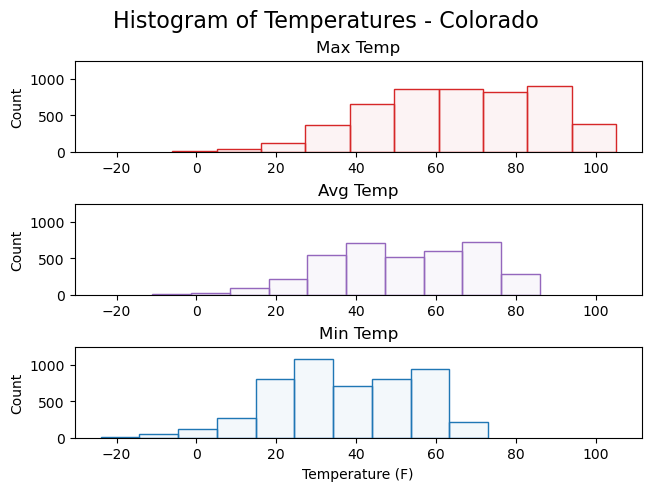

In [17]:
plt.figure(figsize=(12, 6), dpi=80)
fig, axs = plt.subplots(3, sharex=True, constrained_layout=True)
fig.suptitle("Histogram of Temperatures - Colorado",fontsize=16)
# Max. Temp
axs[0].hist(CO_NOAA['Max.Temp'], color='tab:red', alpha=0.05, label="Max Temp", edgecolor='red') # Create translucent fill...
axs[0].hist(CO_NOAA['Max.Temp'],  label="Max. Temp", edgecolor='tab:red', facecolor="None") # ... with opaque edges
axs[0].set_title("Max Temp")
axs[0].tick_params(labelbottom=True)
# Avg. Temp
axs[1].hist(CO_NOAA['Avg.Temp'], color='tab:purple', alpha=0.05, label="Avg Temp", edgecolor='purple')
axs[1].hist(CO_NOAA['Avg.Temp'],  label="Avg. Temp", edgecolor='tab:purple', facecolor="None")
axs[1].set_title("Avg Temp")
axs[1].tick_params(labelbottom=True)
# Min Temp
axs[2].hist(CO_NOAA['Min.Temp'], color='tab:blue', alpha=0.05, label="Min Temp", edgecolor='blue')
axs[2].hist(CO_NOAA['Min.Temp'],  label="Min. Temp", edgecolor='tab:blue', facecolor="None")
axs[2].set_title("Min Temp")
axs[2].set_xlabel("Temperature (F)")
for ax in axs.flat:
    ax.set(ylabel="Count",ylim=(0,1250))

### 2.1.4 Boxplot ###
Comparative histograms, especially when comparing each region, may become overwhelming. It may be more convenient and concise to plot these distributions as boxplots.

The following boxplots indicate the same order of averages seen above, and more easily identifying the exact average for each condition.

(-30.0, 115.0)

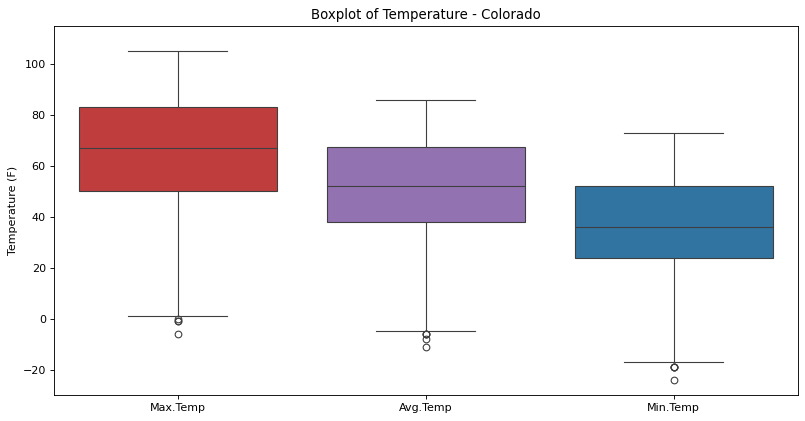

In [18]:
plt.figure(figsize=(12, 6), dpi=80)
sns.boxplot(data=CO_NOAA[['Max.Temp',"Avg.Temp","Min.Temp"]], palette=['tab:red','tab:purple','tab:blue'])
plt.ylabel("Temperature (F)")
plt.title("Boxplot of Temperature - Colorado")
plt.ylim(-30,115)

## 2.2 Precipitation ##
Plotting a single precipitation parameter is much easier than the three temperature parameters. Below are the scatter plot with 1-month moving average, histogram, and boxplots for Colorado's precipitation data.

### 2.2.1 Scatter plot with moving average ###
The precipitation scatter plot shows no clear trend, especially since most entries have 0 precipitation. However, replacing the 0s as NaNs show some seasonal patterns though not as distinctly as the temperature data.

Due to the already large scope of analysis, precipitation comparison between regions will be limited to scatter plots.

In [19]:
def prec_moving_average_plot(df,state = "Colorado", window=""):
    plt.figure(figsize=(12, 4), dpi=80)
    x = df['Date']
    plt.scatter(x,df['Precipitation'], s=1, c='black', alpha=0.1, label="Precipitation")
    # PLotting moving averages
    plt.plot(x,df['Prec.Moving.Avg'], c='black', alpha = 0.5)
    plt.ylabel("Precipitation (in)")
    plt.xlabel("Year")
    # plt.legend(loc = 'lower right', markerscale = 5)
    plt.title(str(state)+" - Precipitation Variation - Moving Average " + str(window))

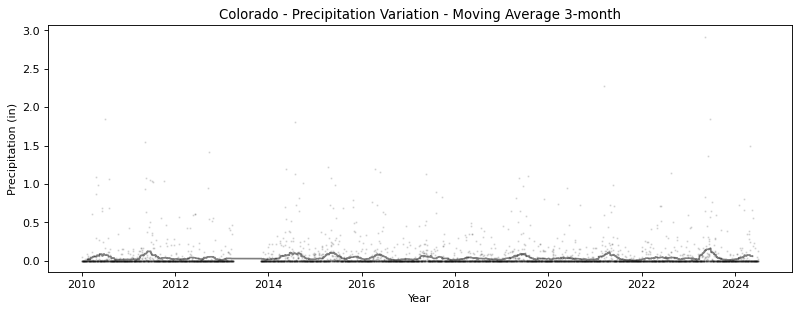

In [20]:
moving_average(CO_NOAA,window_size = 90)
prec_moving_average_plot(CO_NOAA, window = "3-month")

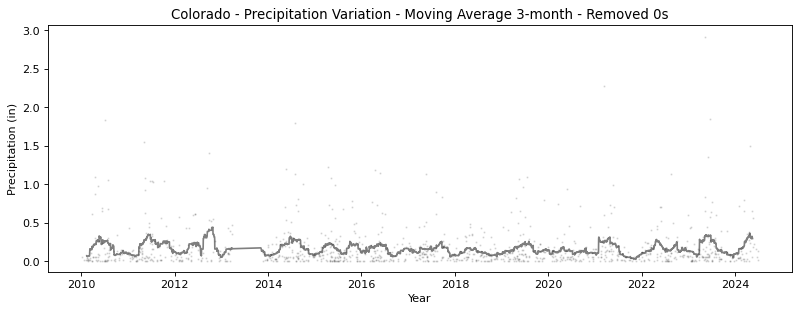

In [21]:
CO_NOAA_copy = CO_NOAA.copy()
CO_NOAA_copy['Precipitation'] = CO_NOAA_copy['Precipitation'].replace(0,np.nan)
moving_average(CO_NOAA_copy,window_size = 90)
prec_moving_average_plot(CO_NOAA_copy, window = "3-month - Removed 0s")

### 2.2.2 Histogram and Boxplot ###
The histogram without 0 precipitation entries highlights the gamma distribution of precipitation. The boxplot plots many of the data points as outliers since the distribution is non-normal, indicating the boxplot is not suitable for precipitation analysis.

<Figure size 640x320 with 0 Axes>

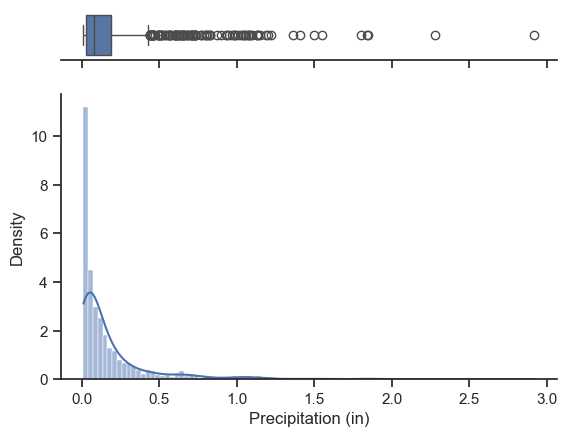

In [22]:
plt.figure(figsize=(8, 4), dpi=80)
sns.set(style="ticks")
x = CO_NOAA_copy['Precipitation']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=x, ax=ax_box)
sns.histplot(x=x, ax=ax_hist, kde=True, stat='density')
ax_box.set(yticks=[])
plt.xlabel("Precipitation (in)")
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

## 2.3 Groundwater ##
Finally we will provide the same plots for groundwater from the USGS database.

### 2.3.1 Scatterplot ###
The scatterplot indicates the increasing groundwater level from 2016 through 2023. Since groundwater level is representative as depth, increasing groundwater level (which might sound positive) indicates indicates groundwater depletion. Luckily There has been some recovery since 2023.

In [23]:
CO_USGS = df_USGS.iloc[df_USGS.index.get_level_values(0).str.contains('Colorado')]
CO_USGS.reset_index(inplace=True)

Text(0.5, 0, 'Year')

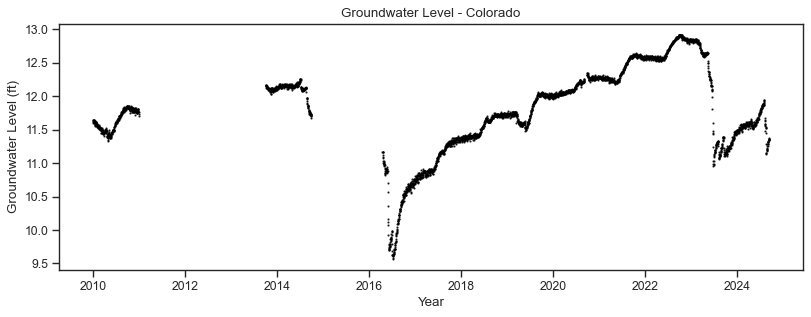

In [24]:
# CO_USGS.info()
plt.figure(figsize=(12, 4), dpi=80)
plt.scatter(CO_USGS['Date'],CO_USGS['Groundwater Level'], s=1, c='black', alpha=0.75, label="Groundwater Level")
plt.title("Groundwater Level - Colorado")
plt.ylabel("Groundwater Level (ft)")
plt.xlabel("Year")

### 2.3.2 Histogram and Boxplot ###
We can also plot the distribution of groundwater level using a histogram and boxplot. Note again the large number of outliers since the data appears non-normal. The distinct long term trends in the data indicate distribution-style analysis is not suitable for the data. As such, the comparative analysis will only include the scatterplots like the precipitation analysis.

<Figure size 640x320 with 0 Axes>

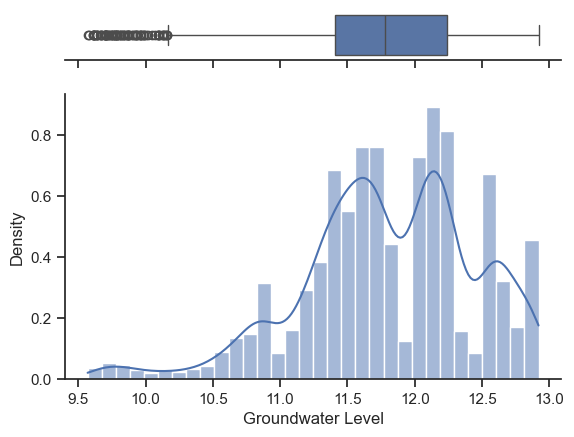

In [25]:
plt.figure(figsize=(8, 4), dpi=80)
sns.set(style="ticks")
x = CO_USGS['Groundwater Level']
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(x=x, ax=ax_box)
sns.histplot(x=x, ax=ax_hist, kde=True, stat='density')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)


## 3. Comparative Analysis ##
With our analytical foundation established for Colorado, we can now compare to the other states.

The comparative analysis is limited to scatterplots for each of the conditions, using moving averages where appropriate. Temperatures will also consider boxplots for comparison, though their inability to demonstrate long term trends is noted.

### 3.1 Temperature Comparison ###
#### 3.1.1 Scatterplot ####
The below function isolates each state's data, performs a 6-month moving average calculation, then compiles the plots for comparison.

Analysis follows the plot since the code is quite long.

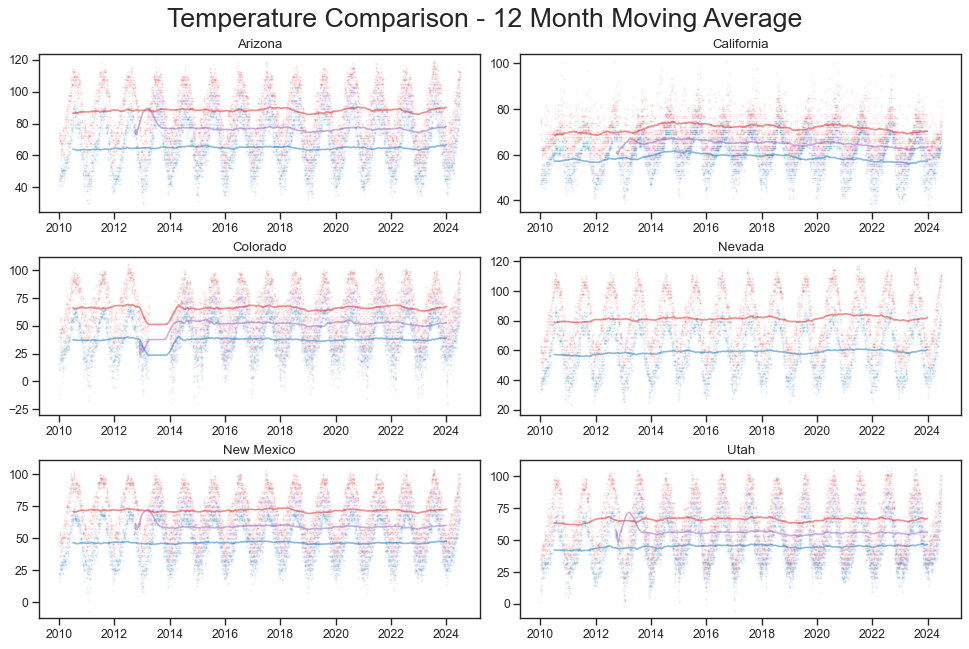

In [26]:
# Initialize 3x2 plot
fig, axs = plt.subplots(3,2,constrained_layout=True,figsize=(12, 8), dpi=80)
j = 0
# For each state...
for i,state in enumerate(NOAA_states):      
    # Isolate data by state
    temp_NOAA = df_NOAA.iloc[df_NOAA.index.get_level_values(0).str.contains(str(state))]
    temp_NOAA.reset_index(inplace=True)
    # Calculate moving average
    moving_average(temp_NOAA,window_size = 364)
    # Determine index for plot
    k = i
    if i > 1:
        j = 1 # row
        k = i - 2 # column
    if i > 3:
        j = 2 
        k = i - 4
    # print(i,j,k)
    
    x = temp_NOAA['Date']
    axs[j,k].scatter(x,temp_NOAA['Max.Temp'], s=1, c='tab:red', alpha=0.05, label="Max Temp")
    axs[j,k].scatter(x,temp_NOAA['Avg.Temp'], s=1,  c='tab:purple', alpha=0.05, label="Avg Temp")
    axs[j,k].scatter(x,temp_NOAA['Min.Temp'], s=1,  c='tab:blue', alpha=0.05, label="Min Temp")
    # PLotting moving averages
    axs[j,k].plot(x,temp_NOAA['Max.Moving.Avg'], c='tab:red', alpha = 0.5)
    axs[j,k].plot(x,temp_NOAA['Avg.Moving.Avg'], c='tab:purple', alpha = 0.5)
    axs[j,k].plot(x,temp_NOAA['Min.Moving.Avg'], c='tab:blue', alpha = 0.5)
    # axs[j,k].legend(loc = 'lower right', markerscale = 5)
    axs[j,k].set_title(str(state))
    # show plot
fig.suptitle("Temperature Comparison - 12 Month Moving Average", fontsize=24)
plt.show()

While these plots are pretty, it is still difficult to interpret their long term trends or similiarities. We can instead plot the moving averages on the same plot, shown below.

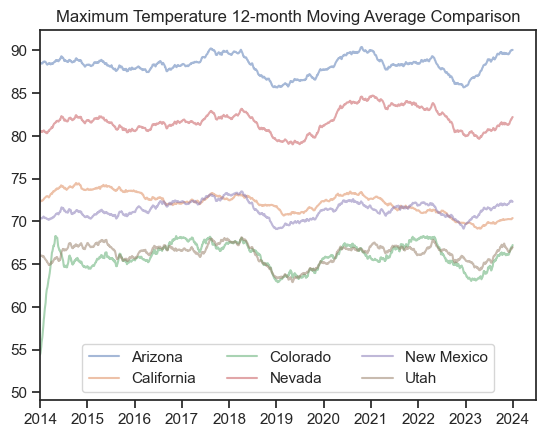

In [27]:
# For each state...
for i,state in enumerate(NOAA_states):      
    # Isolate data by state
    temp_NOAA = df_NOAA.iloc[df_NOAA.index.get_level_values(0).str.contains(str(state))]
    temp_NOAA.reset_index(inplace=True)
    # Calculate moving average
    moving_average(temp_NOAA,window_size = 364)
    # Determine index for plot
    x = temp_NOAA['Date']
    plt.plot(x,temp_NOAA['Max.Moving.Avg'], alpha = 0.5,label=state)
plt.xlim([datetime.date(2014, 1, 1), datetime.date(2024, 6, 30)])
plt.legend(loc = 'lower center', ncol=3)
plt.title("Maximum Temperature 12-month Moving Average Comparison") 
plt.show()

The plot has been limited to 2014 to 2024 to avoid the artifacts of missing data during 2013. However, the plot shows the gradual increase in temperature from 2016 through early 2018, followed by a dramatic decline beginning in mid 2018. Temperature then recovered, with another decrease in mid 2022 before recovery. It is hard to determine from this plot alone a long term increasing trend, especially given the dramatic swings in 2018 and 2022.

Note the moving average nature of the plot may make it more challenging to interpret, especially since this moving average considers both future and past temperatures. A more standard moving average only uses past information. Note that this calculation of moving average does not affect the trends themselves, but different approaches would shift the plot in time.

Regardless, I find it surprising how similiar the trends in temperature are across the various states. Arizona and Nevada show surprising correlation, even to hot and cold spots. I presume the California data (sourced from San Diego) is tempered by the ocean which may smooth temperature variation found in the drier states.

#### 3.1.2 Boxplot ####
The below boxplot is included for a simplified distribution comparison. Again since this distribution analysis does not capture the long term trends we are interested in for climate change analysis, these will not be analyzed in dramatic detail.

However, this plot does make it apparent states like Arizona and Nevada have higher average temperatures, while avoiding the cold winters found in Colorado, New Mexico, and Utah. The very low variance in San Diego, California again reinforces the stabilizing effect of oceans and California's renowned nice weather. 

Text(0, 0.5, 'Temperature (F)')

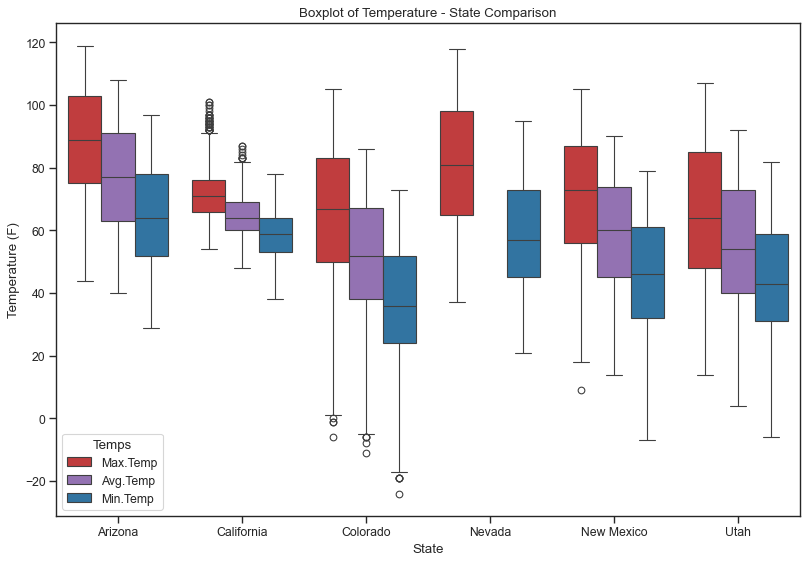

In [28]:
# df_NOAA.reset_index(inplace=True)
df_NOAA_melt=pd.melt(df_NOAA.reset_index(),id_vars=['State'],value_vars=['Max.Temp',"Avg.Temp","Min.Temp"],var_name="Temps")
plt.figure(figsize=(12, 8), dpi=80)
sns.boxplot(data=df_NOAA_melt, x='State', y='value', hue="Temps",palette=['tab:red','tab:purple','tab:blue'])
plt.title("Boxplot of Temperature - State Comparison")
plt.ylabel("Temperature (F)")

### 3.2 Precipitation Comparison ###
For simplicity the precipitation comparison will be limited to scatterplots, using similar code as before.

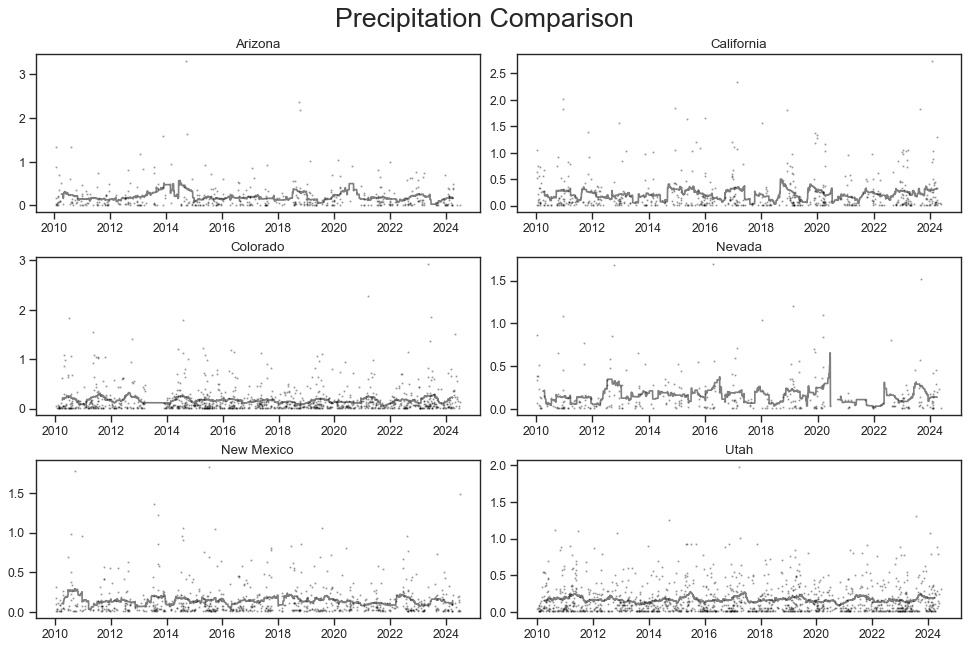

In [29]:
fig, axs = plt.subplots(3,2,constrained_layout=True,figsize=(12, 8), dpi=80)
j = 0
for i,state in enumerate(NOAA_states): # enumerate instead     
    # isolate data by state
    temp_NOAA = df_NOAA.iloc[df_NOAA.index.get_level_values(0).str.contains(str(state))]
    temp_NOAA.reset_index(inplace=True)
    temp_NOAA["Precipitation"] = temp_NOAA["Precipitation"].replace(0, np.nan)
    moving_average(temp_NOAA,window_size = 184)
    # Axis ploting per state i
    k = i
    if i > 1:
        j = 1 # row
        k = i - 2 # column
    if i > 3:
        j = 2 
        k = i - 4
    # print(i,j,k)
    x = temp_NOAA['Date']
    axs[j,k].scatter(x,temp_NOAA['Precipitation'], s=1, c='black', alpha=0.25, label="Max Temp")
    axs[j,k].plot(x,temp_NOAA['Prec.Moving.Avg'], c='black', alpha = 0.5)
    axs[j,k].set_title(str(state))
    # show plot
fig.suptitle("Precipitation Comparison", fontsize=24)
plt.show()

Again the precipitation plots are much harder to interpret than the temperature plots. We will compare the 3-year moving averages to reduce noise.

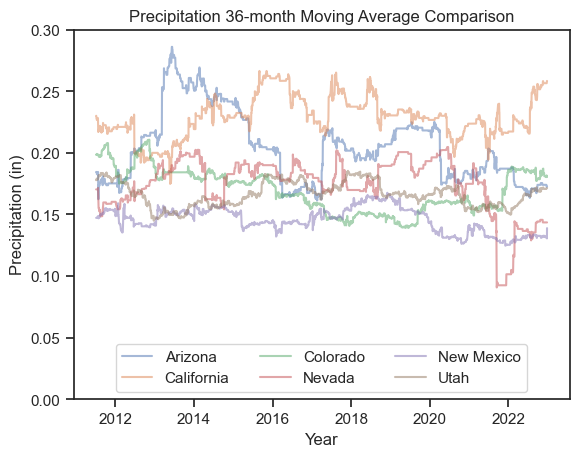

In [30]:
# For each state...
for i,state in enumerate(NOAA_states):      
    # Isolate data by state
    temp_NOAA = df_NOAA.iloc[df_NOAA.index.get_level_values(0).str.contains(str(state))]
    temp_NOAA.reset_index(inplace=True)
    temp_NOAA["Precipitation"] = temp_NOAA["Precipitation"].replace(0, np.nan)
    # Calculate moving average
    moving_average(temp_NOAA,window_size = 1100)
    # Determine index for plot
    x = temp_NOAA['Date']
    plt.plot(x,temp_NOAA['Prec.Moving.Avg'], alpha = 0.5,label=state)
# plt.xlim([datetime.date(2014, 1, 1), datetime.date(2024, 6, 30)])
plt.ylim([0,0.3])
plt.ylabel("Precipitation (in)")
plt.xlabel("Year")
plt.legend(loc = 'lower center', ncol=3)
plt.title("Precipitation 36-month Moving Average Comparison") 
plt.show()

These precipitation plots are much more difficult to interpret due to their overlapping and criss-crossing nature. However, with a keen eye we can explore some state-specific trends. For example, Colorado appeared to be in decline for precipitation for many years, but has recently seen a dramatic increase. This is unlike New Mexico which has instead seen steady decline in the past few years. Nevada too maintained relatively consistent precipitation for several years, but saw a significant decline in the years surrounding late 2021 (again due to moving average, 2021 on the plot captures average precipitation from 2020-2022).

The plot is again inconclusive for ternds of constant increase or decrease in precipitaion. Precipitation is more volatile, considering drought or flood conditions, especially in areas subject to ENSO.

### 3.3 Groundwater Comparison ###
Finally we will compare the scatter plots for groundwater from the USGS database.

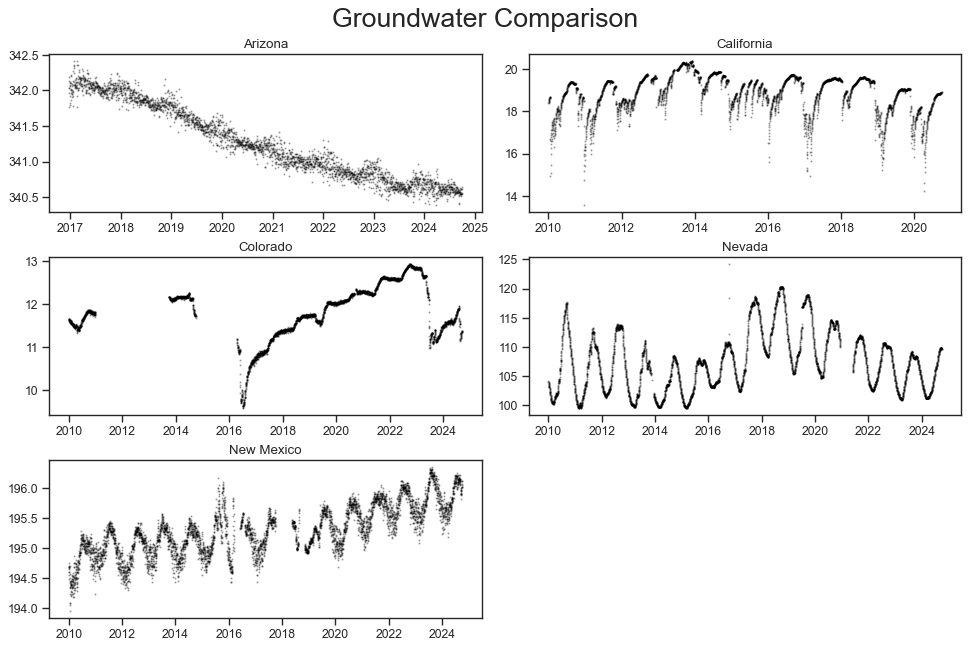

In [31]:
fig, axs = plt.subplots(3,2,constrained_layout=True,figsize=(12, 8), dpi=80)
j = 0
for i,state in enumerate(USGS_states): # enumerate instead     
    # isolate data by state
    temp_USGS = df_USGS.iloc[df_USGS.index.get_level_values(0).str.contains(str(state))]
    temp_USGS.reset_index(inplace=True)
    # Axis ploting per state i
    k = i
    if i > 1:
        j = 1 # row
        k = i - 2 # column
    if i > 3:
        j = 2 
        k = i - 4
    # print(i,j,k)
    x = temp_USGS['Date']
    axs[j,k].scatter(x,temp_USGS['Groundwater Level'], s=1, c='black', alpha=0.25)
    axs[j,k].set_title(str(state))
    # show plot
axs[2,1].set_axis_off()
fig.suptitle("Groundwater Comparison", fontsize=24)
plt.show()

The groundwater plots are surprisingly interesting! Recall that increasing groundwater level indicates a reduction in available groundwater. Thus, groundwater trends such as in Arizona indicate gradual recovery of groundwater, though at only inches per year. Increasing plots, such as those in Colorado and New Mexico indicate gradual reduction in available groundwater. The seasonal trends in New Mexico are also clearly apparent in Nevada, which have much larger swings in groundwater, with recent years in recovery. Finally trends in California seems to have periods of rapid decline, before the groundwater level evens out. While this appears to be seasonal or annual, the variation in 2015 indicates more frequent use of groundwater resources.

What I find interesting in comparing these plots is there is no singular trend among them. While seasonal variation is very distinct in New Mexico, Nevada, and arguably in California, it is much less dramatic in Colorado and Arizona. The wide magnitude of change is also interesting, with Nevada groundwater varying by several feet in a year, while Arizona takes several years to vary by a single foot. I presume this is is the problem of using a single measurement (groundwater level) to represent a volume (total groundwater).

Given the wide mix of groundwater trends, again it is hard to draw clear conclusions for the collective region from this analysis.

## 4. Conclusion ##
This analysis considered many aspects of climate change analysis in data science. Technically it emphasized API data collection, including working within API limitations for automation. Given the large datasets, data manipulation was key to consolidate data, isolate different states, and create moving averages. Finally many visualization techniques for subplots and cross plotting were explored for comparative analysis.

Temperature analysis highlighted the seasonality of temperature variation, as well as the natural variance that makes interpreting raw data challenging. Precipitation analysis indicated issues when working with high-0 datasets and the merits of removing those points from analysis. However, it too showed large variation in raw data or of the measured variable making interpretation difficult. Finally groundwater analysis from USGS showed how much easier an API could be, and showed far less variation in raw data which required effectively no post processing. 

While none of the plots clearly showed expected climate change trends (gradually increasing temperatures, changes to precipitation, depletion of groundwater), the analysis is a reminder that climate change effects are slow and not necessarily direct. It was interesting to see temperature variation align so closely, as well as the dramatic variation between states for precipitation and groundwater. It may be an artifact of the American global perspective to imagine 'The American Southwest' as a climate region, despite the vast distance and differences between each region, evident in this analysis.

Given more time, this analysis could make several convenience changes in the code. For example, the NOAA and USGS dataframes could easily be consolidated. Subplots could rely on `plt.subplot(rows,columns,index)` to avoid calculating the row and column position manually. The data could be distilled further, for example isolating the top 100 temperature measurements per year, though this likely introduces bias into the analysis. The analysis could also consider a smaller region, especially since the effects of climate change locally and globally can be very different.

In any case, I found the project interesting to work on and a fun challenge to implement.